# Binary Classification on Synthetic Data with an LDA Head
This notebook builds a toy 2D dataset, trains a small encoder paired with an LDA head, and visualises the resulting decision boundary.


### Setup


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.lda import LDAHead

### Generate Synthetic Dataset


In [2]:
# Two Gaussian clusters in 2D for binary classification.
mean0 = torch.tensor([-2.0, 0.0])
mean1 = torch.tensor([2.0, 0.5])
cov0 = torch.tensor([[1.0, 0.2], [0.2, 1.2]])
cov1 = torch.tensor([[1.3, -0.3], [-0.3, 1.0]])

gen0 = torch.distributions.MultivariateNormal(mean0, covariance_matrix=cov0)
gen1 = torch.distributions.MultivariateNormal(mean1, covariance_matrix=cov1)

def sample_split(n_total):
    n_per_class = n_total // 2
    x0 = gen0.sample((n_per_class,))
    x1 = gen1.sample((n_per_class,))
    x = torch.cat([x0, x1], dim=0)
    y = torch.cat([
        torch.zeros(n_per_class, dtype=torch.long),
        torch.ones(n_per_class, dtype=torch.long)
    ])
    # Shuffle to mix classes.
    idx = torch.randperm(x.size(0))
    return x[idx], y[idx]

train_X, train_y = sample_split(20_000)
test_X, test_y = sample_split(4_000)

train_ds = TensorDataset(train_X, train_y)
test_ds = TensorDataset(test_X, test_y)

train_ld = DataLoader(train_ds, batch_size=256, shuffle=True)
test_ld = DataLoader(test_ds, batch_size=1024, shuffle=False)

train_X[:5], train_y[:5]

(tensor([[ 2.1423, -0.5061],
         [ 1.9830,  0.2758],
         [-2.7632, -0.3650],
         [-3.7693,  1.1999],
         [-2.8502, -1.5148]]),
 tensor([1, 1, 0, 0, 0]))

### Model: small encoder + LDA head


In [3]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(inplace=True),
            nn.Linear(32, dim)
        )

    def forward(self, x):
        return self.net(x)

class DeepLDA(nn.Module):
    def __init__(self, C, D, ema=0.9):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = LDAHead(C, D, ema, diag_cov=True)

    def forward(self, x, y=None):
        z = self.encoder(x)
        return self.head(z, y)

### Training Utilities


In [4]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ok = tot = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        ok += (logits.argmax(dim=1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

### Train Model


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

model = DeepLDA(C=2, D=2, ema=0.9).to(device)
opt = torch.optim.Adam(model.encoder.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, 16):
    model.train()
    loss_sum = tot = correct = 0
    for X, y in train_ld:
        X, y = X.to(device), y.to(device)
        logits = model(X, y)
        loss = loss_fn(logits, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            tot += y.size(0)
            loss_sum += loss.item() * y.size(0)

    train_acc = correct / tot
    test_acc = evaluate(model, test_ld, device)
    print(f"[epoch {epoch:02d}] train loss={loss_sum/tot:.4f} acc={train_acc:.4f} | test acc={test_acc:.4f}")

device = cuda
[epoch 01] train loss=0.0830 acc=0.9700 | test acc=0.9730
[epoch 02] train loss=0.0779 acc=0.9702 | test acc=0.9738
[epoch 03] train loss=0.0774 acc=0.9708 | test acc=0.9740
[epoch 04] train loss=0.0770 acc=0.9710 | test acc=0.9730
[epoch 05] train loss=0.0769 acc=0.9708 | test acc=0.9735
[epoch 06] train loss=0.0766 acc=0.9709 | test acc=0.9740
[epoch 07] train loss=0.0758 acc=0.9706 | test acc=0.9722
[epoch 08] train loss=0.0757 acc=0.9714 | test acc=0.9730
[epoch 09] train loss=0.0760 acc=0.9704 | test acc=0.9738
[epoch 10] train loss=0.0764 acc=0.9708 | test acc=0.9732
[epoch 11] train loss=0.0765 acc=0.9705 | test acc=0.9738
[epoch 12] train loss=0.0754 acc=0.9714 | test acc=0.9738
[epoch 13] train loss=0.0752 acc=0.9714 | test acc=0.9722
[epoch 14] train loss=0.0759 acc=0.9712 | test acc=0.9738
[epoch 15] train loss=0.0761 acc=0.9708 | test acc=0.9738


In [6]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

DeepLDA(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (head): LDAHead()
)

### Collect a Small Random Subset of Embeddings


In [7]:
emb_list, y_list = [], []
max_points = int(len(train_ld.dataset) * 0.05)

with torch.no_grad():
    for X, y in train_ld:
        X, y = X.to(device), y.to(device)
        z = model.encoder(X)
        emb_list.append(z)
        y_list.append(y)
        if sum(t.shape[0] for t in emb_list) >= max_points:
            break

Z = torch.cat(emb_list, dim=0).cpu().numpy()[:max_points]
Y = torch.cat(y_list, dim=0).cpu().numpy()[:max_points]

### Inspect Learned Statistics


In [8]:
mu = model.head.mu_ema.detach().cpu()  # (C, K, D) or (C*K, D)

### Visualise Embeddings


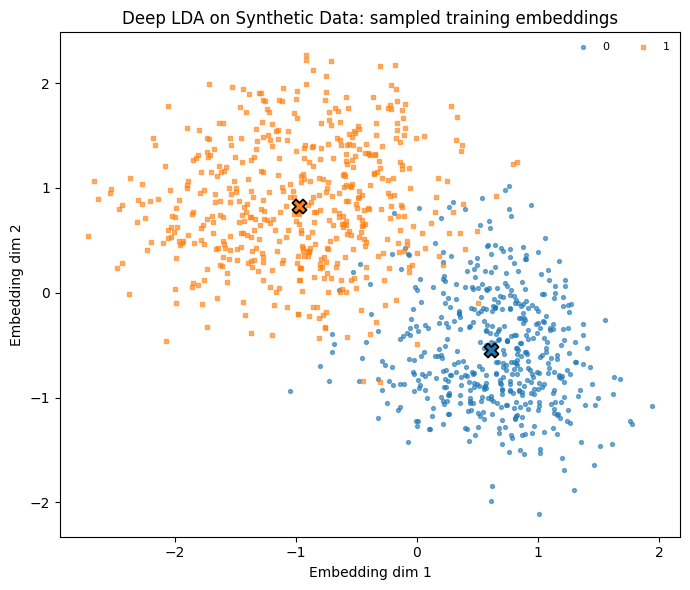

In [9]:
plt.figure(figsize=(7,6))
cmap = plt.get_cmap("tab10", 10)
markers = ['o','s']

for c in range(2):
    idx = (Y == c)
    plt.scatter(Z[idx,0], Z[idx,1], s=8, alpha=0.6,
                c=[cmap(c)], marker=markers[c], label=f"{c}")
    for k in range(mu.shape[1]):
        m = mu[c]
        plt.scatter(m[0], m[1], s=100, marker='X',
                    c=[cmap(c)], edgecolor='k', linewidths=1.2)

plt.title("Deep LDA on Synthetic Data: sampled training embeddings")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.legend(fontsize=8, ncol=2, frameon=False)
plt.tight_layout()
plt.show()